### Evaluierung auf dem PlantDoc-Datensatz
* Für jede Evaluierung wird der Seed, mit dem das Modell trainiert wurde genommen, um das Trainings- und Testset wieder GENAU so zu splitten wie im Training.
* Für Modell C und D heißt das, dass sie genau die Daten als Test bekommen, die sie im Training nie gesehen haben

In [1]:
# ÄNDERN BEI JEDEM UNTERSCHIEDLICHEN EXPERIMENTLAUF
EXPERIMENT_SEED = 42 # Mögliche Werte: 42, 43, 44
MODEL_TYPE = "A"        # Mögliche Werte: "A", "B"

In [2]:
import pathlib
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import keras

# --- KONFIGURATION ---
PLANTDOC_DIR = '/mnt/c/Users/sandr/Desktop/Studium/thesis/praxis/data/plantdoc_cropped'
IMG_SIZE = (224, 224) 
BATCH_SIZE = 16

# Modell laden
print(f"Lade Modell: models/model_{MODEL_TYPE}_seed_{EXPERIMENT_SEED}.keras")
current_model = keras.models.load_model(f"models/model_{MODEL_TYPE}_seed_{EXPERIMENT_SEED}.keras")

try:
    print("Starte Daten-Vorbereitung für Evaluation mit GROUP-AWARE SPLIT...")
    
    data_dir = pathlib.Path(PLANTDOC_DIR)

    # 1. Sortieren für deterministische Reihenfolge
    image_paths = sorted(list(data_dir.glob('*/*')))
    image_paths = [str(path) for path in image_paths if not pathlib.Path(path).name.startswith('.')]

    # 2. Klassennamen aus den Ordnernamen extrahieren
    class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
    class_to_index = {name: i for i, name in enumerate(class_names)}
    NUM_CLASSES = len(class_names)
    
    # 3. Labels und GROUP IDs extrahieren
    all_labels = []
    all_groups = []

    for path in image_paths:
        # Label
        label = class_to_index[pathlib.Path(path).parent.name]
        all_labels.append(label)
        
        # Group ID (Originalbild-Name) extrahieren
        filename = os.path.basename(path)
        if "_crop_" in filename:
            group_id = filename.rsplit("_crop_", 1)[0]
        else:
            group_id = filename
        all_groups.append(group_id)
    
    print(f"Gesamt: {len(image_paths)} Bilder in {NUM_CLASSES} Klassen.")

    # 4. Stratified Group Split (REKONSTRUKTION DES TRAININGS-SPLITS)
    # Exakt dieselben Parameter wie im individuellen Training
    cv_test = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=EXPERIMENT_SEED)
    
    # Erstee Split 
    _, test_idx = next(cv_test.split(image_paths, all_labels, all_groups))
    
    # Filtern der Pfade und Labels basierend auf den Indizes
    test_paths = [image_paths[i] for i in test_idx]
    test_labels = [all_labels[i] for i in test_idx]
    
    print(f"Group-Aware Split rekonstruiert. Test-Set Größe: {len(test_paths)} Bilder")

   # Funktion zum Laden und Preprocessing
    def load_and_preprocess_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, tf.one_hot(label, NUM_CLASSES)
    
    # Hilfsfunktion zum Erstellen des tf.data.Dataset
    def create_dataset(paths, labels):
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds

    # Erstelle das Test-Dataset
    test_dataset_PD = create_dataset(test_paths, test_labels)

except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")
    import traceback
    traceback.print_exc()

print("Erstellen des PlantDoc-Testsets abgeschlossen!")

2026-01-10 11:07:00.162736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-10 11:07:00.307463: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-10 11:07:00.308625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-10 11:07:00.532525: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-10 11:07:01.647744: W tensorflow/compiler/tf

Lade Modell: models/model_A_seed_42.keras


2026-01-10 11:07:04.320087: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-10 11:07:04.578336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-10 11:07:04.578406: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-10 11:07:04.581056: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-10 11:07:04.581117: I external/local_xla/xla/stream_executor

Starte Daten-Vorbereitung für Evaluation mit GROUP-AWARE SPLIT...
Gesamt: 8589 Bilder in 27 Klassen.
Group-Aware Split rekonstruiert. Test-Set Größe: 1823 Bilder
Erstellen des PlantDoc-Testsets abgeschlossen!


### Evaluation auf PlantDoc

In [3]:
print("Starte Vorhersage auf dem PlantDoc Test-Set...")

# Listen für die echten Labels und die Vorhersagen
y_true_list = []
y_pred_list = []

for images, labels in test_dataset_PD:
    
    # 1. Holen der echten Labels für diesen Batch (in one-hot)
    if labels.ndim > 1 and labels.shape[1] > 1:
        y_true_list.append(np.argmax(labels.numpy(), axis=1))
    else:
        y_true_list.append(labels.numpy())
    
    # 2. Vorhersagen NUR FÜR DIESEN BATCH
    pred_probs = current_model.predict_on_batch(images)
    
    # 3. Umwandeln der Vorhersagen in Klassen-Indizes
    y_pred_list.append(np.argmax(pred_probs, axis=1))

# Konvertieren der Listen von Batches in ein langes Array
y_true_labels = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# 4. Metriken berechnen
accuracy = accuracy_score(y_true_labels, y_pred)
f1_macro = f1_score(y_true_labels, y_pred, average='macro', zero_division=0)
precision_macro = precision_score(y_true_labels, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true_labels, y_pred, average='macro', zero_division=0)

# 5. Ergebnisse ausgeben
print(f"Ergebnisse für Modell {MODEL_TYPE} (Seed {EXPERIMENT_SEED}):")
print(f"Finaler Macro F1:      {f1_macro:.4f}")
print(f"Finale Test-Accuracy:  {accuracy*100:.2f} %")
print(f"Finaler Macro Prec.:   {precision_macro:.4f}")
print(f"Finaler Macro Recall:  {recall_macro:.4f}")

Starte Vorhersage auf dem PlantDoc Test-Set...


2026-01-10 11:07:10.593285: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


Ergebnisse für Modell A (Seed 42):
Finaler Macro F1:      0.2444
Finale Test-Accuracy:  26.71 %
Finaler Macro Prec.:   0.3786
Finaler Macro Recall:  0.2993


2026-01-10 11:07:37.300435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Evaluation auf PlantVillage

In [4]:
import pathlib
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight
from tensorflow import keras

PV_DATA_DIR = '/mnt/c/Users/sandr/Desktop/Studium/thesis/praxis/data/plantvillage'

# Pfade und Labels
data_dir = pathlib.Path(PV_DATA_DIR)

# Sortieren für deterministische Reihenfolge
image_paths = sorted(list(data_dir.glob('*/*')))
# Filtern versteckter Dateien
image_paths = [str(path) for path in image_paths if not pathlib.Path(path).name.startswith('.')]

# Klassennamen aus den Ordnernamen extrahieren
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
class_to_index = {name: i for i, name in enumerate(class_names)}
NUM_CLASSES = len(class_names)

print(f"Gesamte Klassen: {NUM_CLASSES}")
print(f"Gesamte Bilder gefunden: {len(image_paths)}")

# Labels für alle Bilder erstellen (als Integers)
all_labels = [class_to_index[pathlib.Path(path).parent.name] for path in image_paths]

# Stratified Split
# Schritt A: Split in Training (80%) und Temporär (20%)
# 'stratify=all_labels' garantiert die gleiche Klassenverteilung
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, all_labels, 
    test_size=0.2, 
    stratify=all_labels, 
    random_state=EXPERIMENT_SEED
)

# Schritt B: Split von Temporär in Validierung (10% gesamt) und Test (10% gesamt)
# 20% Temp-Daten einfach 50/50 aufteilen
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, 
    test_size=0.5, 
    stratify=temp_labels, 
    random_state=EXPERIMENT_SEED
)

print(f"Split Größen -> Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# Funktion zum Laden und Preprocessing eines Bildes
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    # WICHTIG: Integer Label in One-Hot Vektor umwandeln (da label_mode='categorical')
    return img, tf.one_hot(label, NUM_CLASSES)

# Hilfsfunktion zum Erstellen des tf.data.Dataset
def create_dataset(paths, labels, is_training=False):
    # 1. Dataset aus Pfaden und Labels erstellen
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    # 2. Shufflen
    if is_training:
        ds = ds.shuffle(buffer_size=len(paths)) 
        ds = ds.repeat() # Endloses Wiederholen
    
    # Bilder laden
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 4. Batchen und Prefetchen
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

test_dataset_PV = create_dataset(test_paths, test_labels, is_training=False)

# Listen für die echten Labels und die Vorhersagen
y_true_list = []
y_pred_list = []

print("Starte Vorhersage auf dem PlantVillage Test-Set...")

for images, labels in test_dataset_PV:
    
    # 1. Die echten Labels für diesen Batch (in one-hot)
    y_true_list.append(np.argmax(labels.numpy(), axis=1))
    
    # 2. Vorhersagen FÜR DIESEN BATCH
    pred_probs = current_model.predict_on_batch(images)
    
    # 3. Umwandeln der Vorhersagen in Klassen-Indizes
    y_pred_list.append(np.argmax(pred_probs, axis=1))

# Konvertieren der Listen von Batches in ein langes Array
y_true_labels = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# 4. Metriken berechnen
accuracy = accuracy_score(y_true_labels, y_pred)
f1_macro = f1_score(y_true_labels, y_pred, average='macro', zero_division=0)
precision_macro = precision_score(y_true_labels, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true_labels, y_pred, average='macro', zero_division=0)

# 5. Ergebnisse ausgeben
print(f"Finaler Macro F1-Score (PlantVillage) für Modell {MODEL_TYPE} mit Seed {EXPERIMENT_SEED}: {f1_macro:.4f}")
print(f"Finale Test-Accuracy (PlantVillage) für Modell {MODEL_TYPE} mit Seed {EXPERIMENT_SEED}: {accuracy*100:.2f} %")
print(f"Finale Macro Precision (PlantVillage) für Modell {MODEL_TYPE} mit Seed {EXPERIMENT_SEED}: {precision_macro:.4f}")
print(f"Finaler Macro Recall (PlantVillage) für Modell {MODEL_TYPE} mit Seed {EXPERIMENT_SEED}: {recall_macro:.4f}")

Gesamte Klassen: 27
Gesamte Bilder gefunden: 36866
Split Größen -> Train: 29492, Val: 3687, Test: 3687
Starte Vorhersage auf dem PlantVillage Test-Set...
Finaler Macro F1-Score (PlantVillage) für Modell A mit Seed 42: 0.9955
Finale Test-Accuracy (PlantVillage) für Modell A mit Seed 42: 99.67 %
Finale Macro Precision (PlantVillage) für Modell A mit Seed 42: 0.9954
Finaler Macro Recall (PlantVillage) für Modell A mit Seed 42: 0.9957


2026-01-10 11:08:27.088532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Confusion Matrix

--- Generiere Confusion Matrix ---
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step


2026-01-10 11:08:48.403003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



ROHDATEN CONFUSION MATRIX (Modell A, Seed 42)


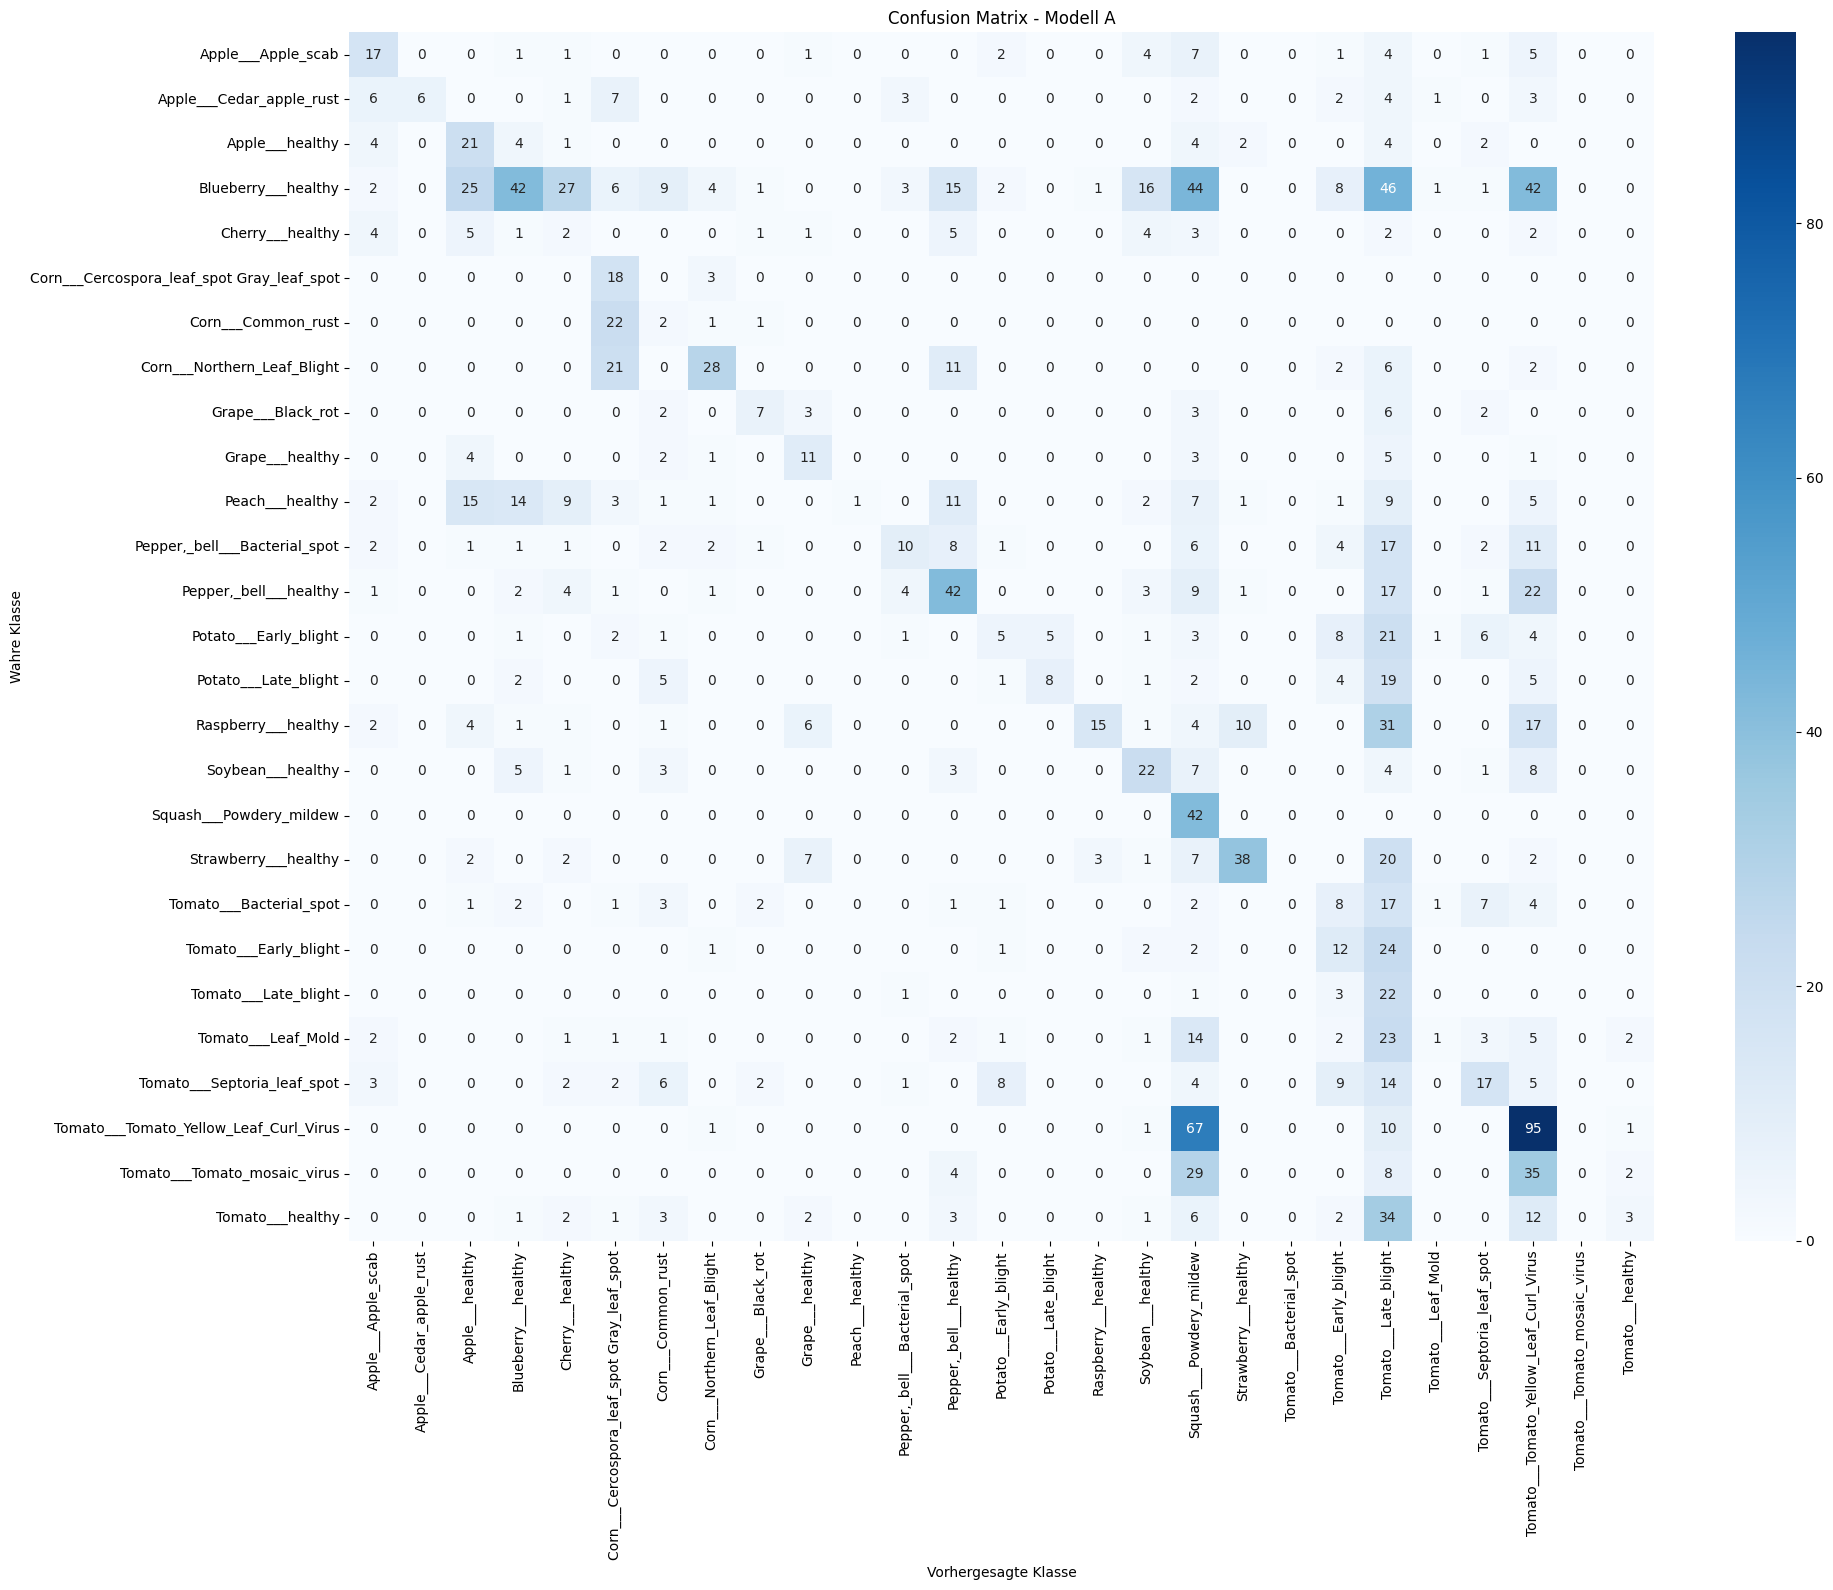

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
print("--- Generiere Confusion Matrix ---")

# 1. Vorhersagen holen
predictions = current_model.predict(test_dataset_PD)
y_pred = np.argmax(predictions, axis=1)

# 2. Wahre Labels holen
y_true = np.concatenate([y for x, y in test_dataset_PD], axis=0)
# Falls Labels One-Hot encodiert sind (was bei dir der Fall ist durch label_mode='categorical')
y_true = np.argmax(y_true, axis=1)

# 3. Matrix berechnen
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

print("\n" + "="*50)
print(f"ROHDATEN CONFUSION MATRIX (Modell {MODEL_TYPE}, Seed {EXPERIMENT_SEED})")
print("="*50)

# 4. Plotten
plt.figure(figsize=(20, 16)) # Groß machen, da 27 Klassen!
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, # Deine Klassennamen Liste
            yticklabels=class_names)

plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title(f'Confusion Matrix - Modell {MODEL_TYPE}')
plt.xticks(rotation=90) # Labels drehen damit man sie lesen kann
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"model_{MODEL_TYPE}_seed_{EXPERIMENT_SEED}confusion.png")
plt.show()